# AI Ethics Project - STARTER

Personalization is a central aspect of many core AI systems. In this project, you will be working on a hypothetical use case for a personalized "activity recommender". The use case has a medium ethical AI risk level and involves a synthetic dataset.

IDOOU is a mobile app users can leverage to get recommendations on activities they can take in a given area, like “visiting a movie theater”, “visiting a park”, “sightseeing”, “hiking”, or “visiting a library”.


**Problem statement**:

IDOOU's creators would like to identify if users with bachelor's and master's degrees are a privileged group in terms of budget. In other words, do users with higher education credentials beyond high school have a budget >= $300 compared to users of the app who graduated from high school? 

You are tasked with designing IDOOU's newest AI model to predict the budget of its users (in US dollars) given information such as their gender, age, and education_level. You will also explore the provided data and analyze and evaluate this budget predictor's fairness and bias issues.


**Key points**:

- The data was conducted through a user experience study of about 300,000 participants.
- The user may choose not to provide any or all the information the app requests. The training data also reflects this.
- Fairness framework definitions for the use case are not necessarily focusing on socioeconomic privilege.

In [2]:
!pip install aif360
!pip install tensorflow
!pip install jinja2
!pip install fairlearn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


**Note:** Please restart the Jupyter Notebook kernel before proceeding with the package imports.

In [1]:
#You may add additional imports as needed
import pandas as pd
import numpy as np
import seaborn as sns
import tempfile
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from aif360.algorithms.postprocessing import RejectOptionClassification
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from fairlearn.preprocessing import CorrelationRemover

import joblib
import matplotlib.pyplot as plt
from collections import defaultdict

pip install 'aif360[LawSchoolGPA]'


In [2]:
#Load the dataset for this project
act_rec_dataset = pd.read_csv('udacity_ai_ethics_project_data.csv')
act_rec_dataset.head()
df = act_rec_dataset.copy()

## Step 1: Data Pre-Processing and Evaluation

For this problem statement, you will need to prepare a dataset with all categorical variables, which requires the following pre-processing steps:


- Remove the NA values from the dataset
- Convert Age and Budget (in dollars) to categorical columns with the following binning:

> Bins for Age: 18-24, 25-44, 45-65, 66-92

> Bins for Budget: >=300, <300

In [3]:
len(act_rec_dataset)

300000

In [4]:
act_rec_dataset.isna().sum()

Budget (in dollars)         0
Age                         0
Gender                  49799
Education_Level         43592
With children?          83849
Recommended_Activity        0
dtype: int64

In [5]:
act_rec_dataset.dropna(axis=0, subset=['Gender', 'Education_Level'], inplace=True)

In [6]:
len(act_rec_dataset)

213855

In [7]:
act_rec_dataset.isna().sum()

Budget (in dollars)         0
Age                         0
Gender                      0
Education_Level             0
With children?          57538
Recommended_Activity        0
dtype: int64

In [8]:
act_rec_dataset = act_rec_dataset.loc[:, act_rec_dataset.columns != 'With children?']

In [9]:
#FILL IN - the below dataframe should be pre-processed
def age_bins(x):
    if 18 <= x < 25:
        return 'young_adult'
    elif 25 <= x < 45:
        return 'adult'
    elif 45 <= x < 66:
        return 'middle_aged'
    elif 66 <= x < 93:
        return 'elder'
    
def budget_bins(x):
    if x >= 300:
        return 'high_budget'
    else:
        return 'low_budget'
    
act_rec_dataset['Age'] = act_rec_dataset['Age'].apply(lambda x: age_bins(x))
act_rec_dataset['Budget (in dollars)'] = act_rec_dataset['Budget (in dollars)'].apply(lambda x: budget_bins(x))

act_rec_dataset.head()

,Budget (in dollars),Age,Gender,Education_Level,Recommended_Activity
0,high_budget,adult,Transgender,Bachelor’s Degree,Stay in: Watch calming TV
1,high_budget,elder,Other,Bachelor’s Degree,Play: Visit a movie theater
3,low_budget,young_adult,Non-binary,Other,Play: Visit a movie theater
4,high_budget,elder,Non-binary,Master’s Degree,Learn: Visit a library
5,high_budget,adult,Male,Bachelor’s Degree,Play: Go shopping


### Evaluate bias issues in the dataset

Next, let's take a look at potential hints of data bias in the variables, particularly the "Gender", "Age", and "Education" variables.

Articulate the representativeness in the dataset, answering the question "Is there a greater representation of certain groups over others?"

In [10]:
#FILL IN|
#Generate visualizations to understand the representativeness of the dataset

<AxesSubplot:xlabel='Age'>

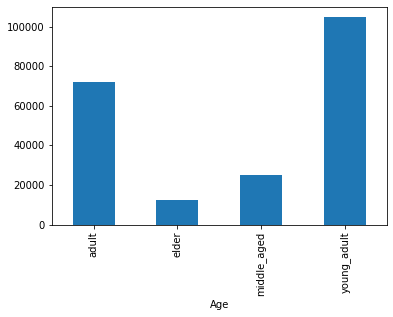

In [11]:
act_rec_dataset.groupby(['Age'])['Age'].count().plot(kind='bar')

<AxesSubplot:xlabel='Gender'>

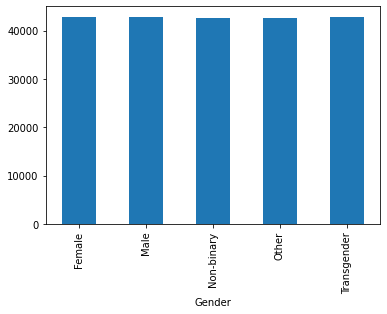

In [12]:
act_rec_dataset.groupby(['Gender'])['Gender'].count().plot(kind='bar')

<AxesSubplot:xlabel='Budget (in dollars)'>

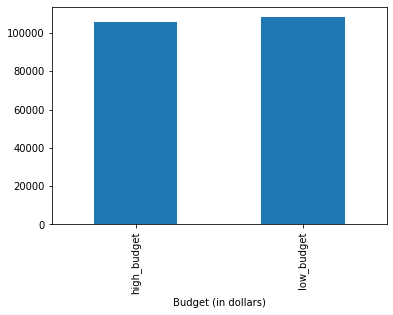

In [13]:
act_rec_dataset.groupby(['Budget (in dollars)'])['Budget (in dollars)'].count().plot(kind='bar')

<AxesSubplot:xlabel='Education_Level'>

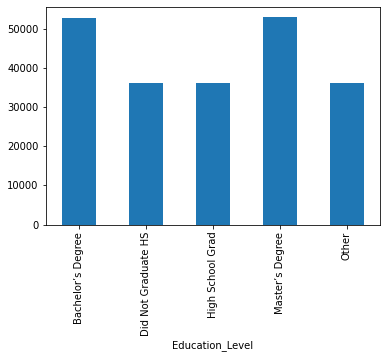

In [14]:
act_rec_dataset.groupby(['Education_Level'])['Education_Level'].count().plot(kind='bar')

<AxesSubplot:xlabel='Age'>

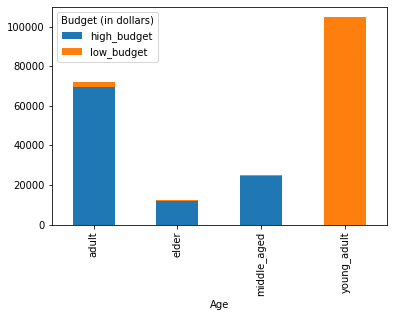

In [15]:
act_rec_dataset.groupby(['Age', 'Budget (in dollars)'])['Age'].count().unstack().plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Gender'>

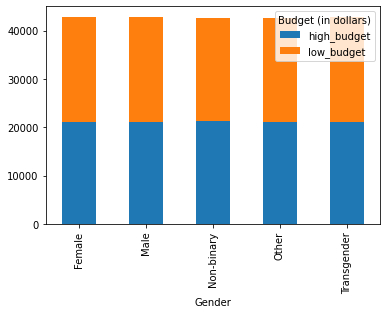

In [16]:
act_rec_dataset.groupby(['Gender', 'Budget (in dollars)'])['Gender'].count().unstack().plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Gender'>

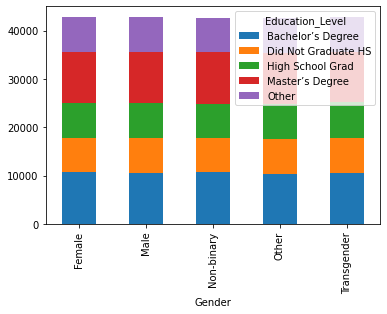

In [17]:
act_rec_dataset.groupby(['Gender', 'Education_Level'])['Gender'].count().unstack().plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Education_Level'>

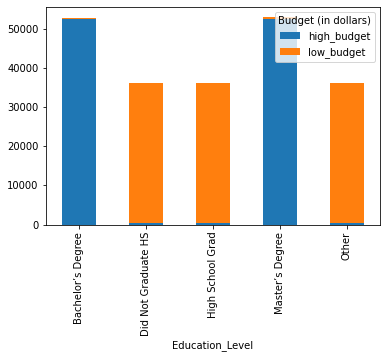

In [18]:
act_rec_dataset.groupby(['Education_Level', 'Budget (in dollars)'])['Education_Level'].count().unstack().plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Age'>

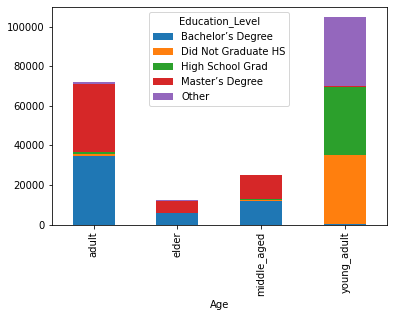

In [19]:
act_rec_dataset.groupby(['Age', 'Education_Level'])['Age'].count().unstack().plot(kind='bar', stacked=True)

Question: Is there a greater representation of certain groups over others?

**Your answer:** We see that for the Age variable, we have significantly more records regarding young adults, followed by those about adults. Regarding the Gender variable, suprisingly, it is equally represented for all of its classes. As for the Education feature, we see that most of the people represented in the dataset have acquired either a BSc or a MSc degree. We also need to keep in mind, that, in order to obtain a MSc degree, a BSc degree is a prerequisite. Therefore, we understand that most of the subjects have at least obtained a BSc diploma (higher/advanced education level). We have to note here that the rows containing missing values in either the Gender or Education_Level column have been removed and the column With children? has been dropped due to the high number of missing values.

Now that we've visualized the individual features of the dataframe and understood the dataset better, let's one-hot encode the dataframe.

In [20]:
#FILL IN: 
#The variable act_rec_dataset should contain the one-hot encoded variables
#categorical_dataset = pd.get_dummies(act_rec_dataset.loc[:, act_rec_dataset.columns != 'Budget (in dollars)'])
categorical_dataset = pd.get_dummies(act_rec_dataset)

Visualize the interactions between the categorical variables. Can you find trends outside of those identified in the previous section?

**Hint**: Use a multicollinearity matrix.

In [21]:
#FILL IN
categorical_dataset.corr()

,Budget (in dollars)_high_budget,Budget (in dollars)_low_budget,Age_adult,Age_elder,Age_middle_aged,Age_young_adult,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Other,...,Education_Level_Other,Recommended_Activity_Explore: Go sightseeing,Recommended_Activity_Explore: Hike,Recommended_Activity_Explore: Visit a park,Recommended_Activity_Learn: Visit a library,Recommended_Activity_Play: Go shopping,Recommended_Activity_Play: Visit a movie theater,Recommended_Activity_Stay in: Color,Recommended_Activity_Stay in: Play a game,Recommended_Activity_Stay in: Watch calming TV
Budget (in dollars)_high_budget,1.000000,-1.000000,0.673073,0.233620,0.345709,-0.967323,-0.000023,-0.000489,0.005014,-0.000965,...,-0.437541,0.241140,0.238393,0.237115,0.239493,-0.408592,-0.410743,0.219856,0.217523,0.221938
Budget (in dollars)_low_budget,-1.000000,1.000000,-0.673073,-0.233620,-0.345709,0.967323,0.000023,0.000489,-0.005014,0.000965,...,0.437541,-0.241140,-0.238393,-0.237115,-0.239493,0.408592,0.410743,-0.219856,-0.217523,-0.221938
Age_adult,0.673073,-0.673073,1.000000,-0.175160,-0.259845,-0.696498,-0.001805,-0.000937,0.003589,-0.000259,...,-0.293231,0.166094,0.163127,0.163038,0.164533,-0.297522,-0.299104,0.172050,0.171558,0.174557
Age_elder,0.233620,-0.233620,-0.175160,1.000000,-0.089780,-0.240650,0.000301,0.000262,0.002208,-0.000524,...,-0.102540,0.056719,0.059417,0.057815,0.059034,-0.100634,-0.103067,0.056782,0.052509,0.059205
Age_middle_aged,0.345709,-0.345709,-0.259845,-0.089780,1.000000,-0.356998,0.000890,0.000060,0.001549,0.000833,...,-0.151073,0.086003,0.085514,0.084261,0.084383,-0.155006,-0.153665,0.089667,0.093721,0.084339
Age_young_adult,-0.967323,0.967323,-0.696498,-0.240650,-0.356998,1.000000,0.000993,0.000726,-0.005415,-0.000048,...,0.422074,-0.238720,-0.236852,-0.235218,-0.237276,0.427779,0.429540,-0.246739,-0.246904,-0.246801
Gender_Female,-0.000023,0.000023,-0.001805,0.000301,0.000890,0.000993,1.000000,-0.250398,-0.249466,-0.249861,...,-0.000446,-0.001585,0.004098,-0.002624,-0.001930,0.000041,0.000373,0.002433,-0.002603,0.001339
Gender_Male,-0.000489,0.000489,-0.000937,0.000262,0.000060,0.000726,-0.250398,1.000000,-0.249835,-0.250230,...,0.000240,-0.001364,-0.000991,-0.002391,0.004872,0.000852,-0.000628,0.000656,-0.000241,-0.000979
Gender_Non-binary,0.005014,-0.005014,0.003589,0.002208,0.001549,-0.005415,-0.249466,-0.249835,1.000000,-0.249299,...,-0.002792,0.004342,0.000599,0.002698,-0.000422,-0.001414,-0.002179,-0.002933,0.002535,0.000364
Gender_Other,-0.000965,0.000965,-0.000259,-0.000524,0.000833,-0.000048,-0.249861,-0.250230,-0.249299,1.000000,...,0.002889,-0.000185,-0.002928,0.001878,0.001773,-0.002008,0.002205,-0.000833,0.000735,-0.000793


In [22]:
##Helper code provided by Fairlearn tutorials
def plot_heatmap(df, title):
    cols = list(df.columns)

    fig, ax = plt.subplots(figsize=(20, 15))
    ax.imshow(round(df.corr(), 2), cmap="coolwarm")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticks(np.arange(len(cols)))
    ax.set_yticklabels(cols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            ax.text(
                j,
                i,
                round(df.corr().to_numpy()[i, j], 2),
                ha="center",
                va="center",
            )

    ax.set_title(f"{title}")
    plt.show()

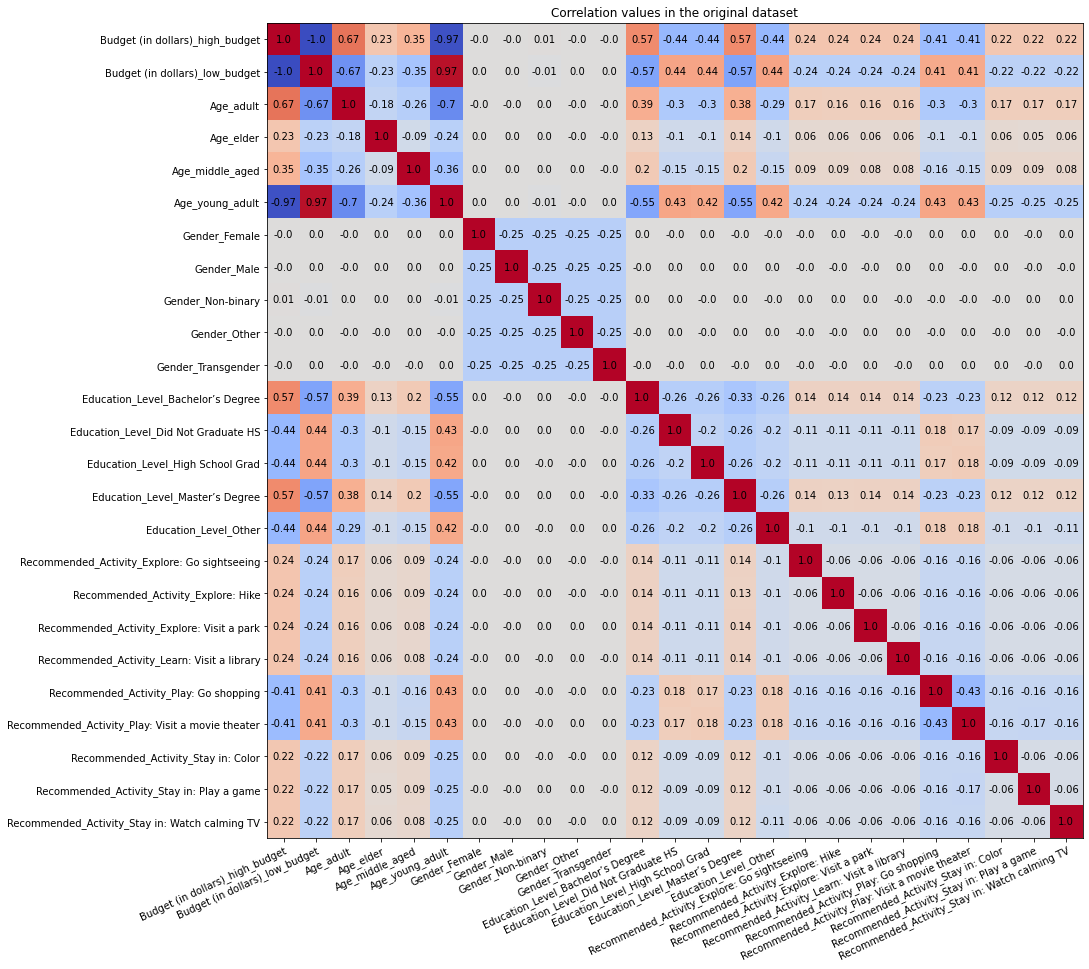

In [23]:
plot_heatmap(categorical_dataset, "Correlation values in the original dataset")

Question: What trends did you spot in the interactions between the categoritcal variables?

**Your answer:** We see that there is a high correlation between the age groups of yound adult, adult and the budget feature. More specifically, we can imply that the younger a person is (out of the app's users), the more likely it is that this person has a low budget. Moreover, there is a weaker correlation between the high levels of education and and the budget feature. In more details, it is slightly more likely for a person with a higher level of education to have a higher budget.

For the purposes of this project, we will drop the following elements from the dataframe:

- Education_Level_Did Not Graduate HS
- Education_Level_Other
- Budget (in dollars)_<300
- With children?

In [24]:
#We drop certain variables that are highly correlated and irrelevant
categorical_dataset = categorical_dataset.drop(columns=['Education_Level_Did Not Graduate HS', 'Education_Level_Other', 'Budget (in dollars)_low_budget'])
categorical_dataset.head()

,Budget (in dollars)_high_budget,Age_adult,Age_elder,Age_middle_aged,Age_young_adult,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Other,Gender_Transgender,...,Education_Level_Master’s Degree,Recommended_Activity_Explore: Go sightseeing,Recommended_Activity_Explore: Hike,Recommended_Activity_Explore: Visit a park,Recommended_Activity_Learn: Visit a library,Recommended_Activity_Play: Go shopping,Recommended_Activity_Play: Visit a movie theater,Recommended_Activity_Stay in: Color,Recommended_Activity_Stay in: Play a game,Recommended_Activity_Stay in: Watch calming TV
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
5,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Evaluate fairness issues

Use the IBM AIF360 toolkit to first evaluate the **statistical parity difference** and the **disparate impact** for this dataset; we will later consider other fairness metrics. Interpret your findings - is there bias in the proposed problem statement? If yes, what group is benefitting?

**Hint**: Use the BinaryLabelDataset and the BinaryLabelDatasetMetric functions for the fairness evaluation. The reported Statistical Parity Difference may be within -0.64 and -0.55, and the Disparate impact value may be within 0.136 and 0.0150.

In [25]:
categorical_dataset.columns

Index(['Budget (in dollars)_high_budget', 'Age_adult', 'Age_elder',
       'Age_middle_aged', 'Age_young_adult', 'Gender_Female', 'Gender_Male',
       'Gender_Non-binary', 'Gender_Other', 'Gender_Transgender',
       'Education_Level_Bachelor’s Degree', 'Education_Level_High School Grad',
       'Education_Level_Master’s Degree',
       'Recommended_Activity_Explore: Go sightseeing',
       'Recommended_Activity_Explore: Hike',
       'Recommended_Activity_Explore: Visit a park',
       'Recommended_Activity_Learn: Visit a library',
       'Recommended_Activity_Play: Go shopping',
       'Recommended_Activity_Play: Visit a movie theater',
       'Recommended_Activity_Stay in: Color',
       'Recommended_Activity_Stay in: Play a game',
       'Recommended_Activity_Stay in: Watch calming TV'],
      dtype='object')

In [26]:
binary_act_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=categorical_dataset,
    label_names=['Budget (in dollars)_high_budget'],
    protected_attribute_names=['Age_middle_aged', 'Age_elder'])

privileged_groups = [{'Age_middle_aged': 1}, {'Age_elder': 1}]
unprivileged_groups = [{'Age_middle_aged': 0, 'Age_elder': 0}]

In [27]:
orig_metric_act_dataset = BinaryLabelDatasetMetric(binary_act_dataset,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("Statistical Parity Difference = %f" % orig_metric_act_dataset.mean_difference())
print(f"Disparate impact: {orig_metric_act_dataset.disparate_impact():.4f}")

Statistical Parity Difference = -0.574263
Disparate impact: 0.4070


Question: Evaluate the fairness metrics. What are your findings? Is there bias in the proposed problem statement? If yes, what group is benefitting?

**Your answer:** Since the Statistical Parity Difference and the Disparate Impact values are less than 0 and 1, respectively, we can conclude that the privileged groups have a higher impact. That is, older people are the group that is benefitting.

## Step 2: Investigate an ML model on the problematic Dataset

For this project, we are using a train-test-validation split.

You have available boilerplate for training 2 ML models on this dataset - you will need to train these models and use the methods we covered in this course to identify and evaluate their performance (**using the accuracy metric and confusion matrix**).

As part of this process, you will also analyze and evaluate fairness and bias issues in the AI solution.

In [28]:
(orig_train,
 orig_validate,
 orig_test) = binary_act_dataset.split([0.5, 0.8], shuffle=True)

In [29]:
#Source: Helper code snippet from https://github.com/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb
def test(dataset, model, thresh_arr):
    y_val_pred_prob = model.predict_proba(dataset.features)
    y_val_pred = model.predict(dataset.features)
    pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs, y_val_pred

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [30]:
GNB_model = GaussianNB().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights) 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, gnb_pred = test(dataset=orig_test,
                   model=GNB_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.9873
Corresponding average odds difference value: -0.3568
Corresponding statistical parity difference value: -0.5869
Corresponding equal opportunity difference value: -0.0011
Corresponding Theil index value: 0.0056


In [31]:
#FILL IN
#Evaluate the accuracy of the model
#Visualize the performance (confusion matrix) of the model
y_train_pred = GNB_model.predict(orig_train.features)
print('The accuracy of the model on the train set is: {:.2f}%'.format(accuracy_score(orig_train.labels.ravel(), y_train_pred)*100))

The accuracy of the model on the train set is: 98.70%


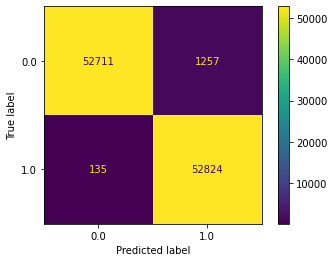

In [32]:
cm = confusion_matrix(orig_train.labels.ravel(), y_train_pred, labels=GNB_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=GNB_model.classes_)
disp.plot()
plt.show()

In [33]:
LR_model = LogisticRegression().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights)

In [34]:
#Load the Logistic Regression model
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, lr_pred = test(dataset=orig_test,
                   model=LR_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.3800
Best balanced accuracy: 0.9957
Corresponding average odds difference value: -0.0021
Corresponding statistical parity difference value: -0.5690
Corresponding equal opportunity difference value: -0.0001
Corresponding Theil index value: 0.0042


In [35]:
#FILL IN
#Evaluate the accuracy of the model
#Visualize the performance (confusion matrix) of the model
y_train_pred = LR_model.predict(orig_train.features)
print('The accuracy of the model on the train set is: {:.2f}%'.format(accuracy_score(orig_train.labels.ravel(), y_train_pred)*100))

The accuracy of the model on the train set is: 99.56%


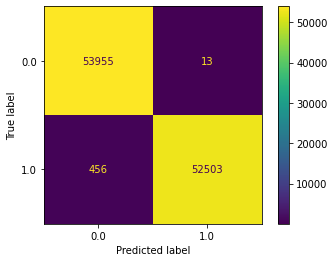

In [36]:
cm = confusion_matrix(orig_train.labels.ravel(), y_train_pred, labels=LR_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=LR_model.classes_)
disp.plot()
plt.show()

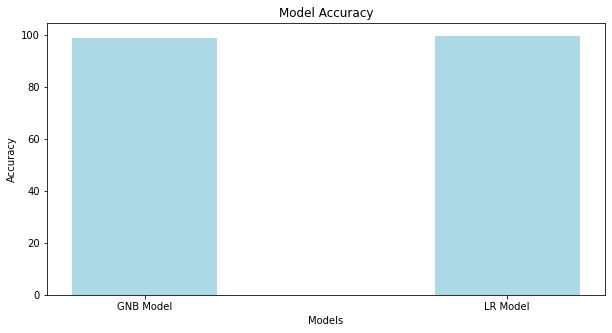

In [37]:
#Fill IN
#Compare the model accuracy on test dataset either in a bar plot or table format

data = {'GNB Model': accuracy_score(orig_test.labels.ravel(), gnb_pred)*100,
        'LR Model': accuracy_score(orig_test.labels.ravel(), lr_pred)*100}
names = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(names, values, color ='lightblue', width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.show()

In [38]:
#FILL IN Optional
#Compare the fairness metrics on test dataset

Question: Interpret and compare the results of each model. What do you find in the false negative and false positive of each model? What about the fairness metrics?

**Your answer:** We see that the accuracy of the Logistic Regression (model 2) is slightly better than the one of the Gaussian Naive Bayes model (model 1). Regarding the confusion matrices, we see that model 1 has more FP than FN, while, for model 2, the other way around applies. Comparing the fairness metrics, we conclude that model 2 has slightly better values overall, meaning that the privileged groups have less benefit in this case compared to model 1.

Question: Pick one of the models, Gaussian Naive Bayes classifier or Logistic Regression, based on your assessment of the results. Briefly explain your reason.

**Your answer:** We will proceed with the second model, since the fairness metrics values do not differ much from the ones of model 1. The reason why we choose the Logistic Regression model is because of smaller FP and that FN > FP. That means that a high-budget user is more likely to be identified as low-budget than the opposite scenario, that is a low-budget user to be classified as a high-budget one. This is good for us because we want the app to make suggestions that the user can be satisfied with and in the case of, the app will suggest low-cost activities which can be afforder by both budget groups. As a result, we will reduce the chances of having a user dissatisfied with the app's recommendations. Finally, the fairness metrics are also better for model 2.

## Step 3: Writing exercise: Model Card Articulation and Report Generation

Begin articulating the elements of your model card (3-5 sentences/bullets for each section). Please delineate bullet points using two hyphens, as show in the example below.

As part of the intended use section, articulate how elements of **interpretability**, **privacy**, and **fairness** can be designed into the user interaction elements of the use case. **Hint:** Should IDOOU prompt the user to check whether the budget predictor model's results are correct?

In [39]:
model_details = """
-- Budget Predicter AI is a model that predicts the budget class of each app user
-- based on the provided information by the user. There two budget classes:
-- low budget: <300 and high budget: >=300.
"""
intended_use = """
-- The use of this model aims to correclty classify the user based on
-- their budget so that it can give suitable, and of course, affordable,
-- activities recommendations.
"""
factors = """
-- The factors considered for the training of the model are:
-- age group
-- gender
-- education level
-- recommended activities
"""

Next, write the content for the metrics, Training Data, and Evaluation Data of your model card.

In [40]:
metrics = """
-- In order to check the validity of the model's results, we used the following metrics:
-- accuracy
-- confusion matrix
-- fairness metrics e.g. statistical parity difference, disparate impact
"""
training_data = """
-- The training data were collected by user input on the specified features mentioned in the factors section.
"""
eval_data = """
-- The data used for evaluation come from a slice of the training data.
"""

## Step 4: Use Interpretability mechanisms

Use an interpretability mechanism(s) of your choice, e.g. permutation importance, LIME, etc., to understand the feature importance and model's predictions on the test dataset. **Visualize** and note down the key contributing factors - you will later incorporate this in your model card.

In [41]:
#FILL IN
#Use an interpretability mechanism to investigate the AI model you chose
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(orig_train.features, orig_train.labels.ravel())

RandomForestClassifier(n_estimators=500, random_state=42)

In [42]:
rf.feature_names = list(orig_train.feature_names)

pfi_importances = pd.Series(
    rf[-1].feature_importances_, index=rf.feature_names
).sort_values(ascending=True)

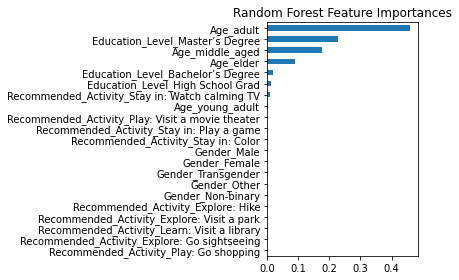

In [43]:
ax = pfi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances")
ax.figure.tight_layout()

Question: Which interpretability mechanism did you choose? What are the key contributing factors?

**Your answer:** The Permutation Feature Importance method that was selected in this case explains which features drive the model’s performance.

## Step 5: Apply a bias mitigation strategy

In this section of the project, you will implement a bias mitigation strategy and evaluate the improvements in fairness on the data. Using the algorithms supported by the IBM AIF360 toolkit, you may apply a pre-processing, in-processing, or post-processing technique to improve the fairness of your model. Optionally, you may also consider combining multiple techniques.

**Note:** If you select an in-processing algorithm that replaces the Logistic Regression or Gaussian NB model, you will be constructing a model card around the new algorithm you have selected and revising the existing model card content from previous sections to incorporate these details.

In [44]:
#FILL IN - implement bias mitigation strategy
#YOUR CODE HERE
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
reweighed_data = RW.fit_transform(binary_act_dataset)

In [45]:
new_metric = BinaryLabelDatasetMetric(reweighed_data, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

print("Statistical Parity Difference = %f" % new_metric.mean_difference())
print(f"Disparate impact: {new_metric.disparate_impact():.4f}")

Statistical Parity Difference = 0.000000
Disparate impact: 1.0000


In [46]:
(orig_train,
 orig_validate,
 orig_test) = reweighed_data.split([0.5, 0.8], shuffle=True)

In [47]:
#FILL IN
#Obtain the new metric values after applying your bias mitigation strategy

LR_model = LogisticRegression().fit(orig_train.features, orig_train.labels.ravel(), orig_train.instance_weights) 
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics, lr_pred = test(dataset=orig_test,
                   model=LR_model,
                   thresh_arr=thresh_arr)
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.3600
Best balanced accuracy: 0.9932
Corresponding average odds difference value: -0.0104
Corresponding statistical parity difference value: 0.0060
Corresponding equal opportunity difference value: 0.0025
Corresponding Theil index value: 0.0048


**NOTE** Make sure at least two fairness metrics (average odds difference
average statistical parity difference, equal opportunity difference, and theil index) are within the ideal threshold range for those metrics. A slightly higher benefit for the privileged group may still be seen, which is ok.

Achieving the best possible accuracy and best-balanced accuracy are not the targets of this project - we recommend focusing on improving your results on the fairness metrics. It is recommended to have your balanced accuracy between 85%-100% but not required.

**IMPORTANT! If less than two fairness metrics are within the ideal range, re-work on your strategy.**

Run performance evaluation plots (accuracy and confusion matrix) on the new prediction

In [48]:
### FILL IN
y_train_pred = LR_model.predict(orig_train.features)
print('The accuracy of the model on the train set is: {:.2f}%'.format(accuracy_score(orig_train.labels.ravel(), y_train_pred)*100))

The accuracy of the model on the train set is: 99.58%


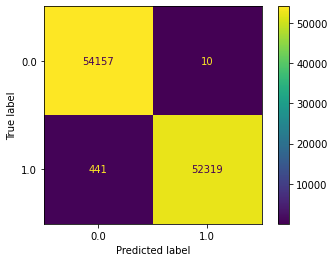

In [49]:
cm = confusion_matrix(orig_train.labels.ravel(), y_train_pred, labels=LR_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=LR_model.classes_)
disp.plot()
plt.show()

In [50]:
plt.savefig('confusion_matrix_mitigation.png')

<Figure size 432x288 with 0 Axes>

Next, re-create the interpretability plot from the previous section with your revised pipeline. 

In [51]:
### FILL IN
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(orig_train.features, orig_train.labels.ravel())

RandomForestClassifier(n_estimators=500, random_state=42)

In [52]:
rf.feature_names = list(orig_train.feature_names)

pfi_importances = pd.Series(
    rf[-1].feature_importances_, index=rf.feature_names
).sort_values(ascending=True)

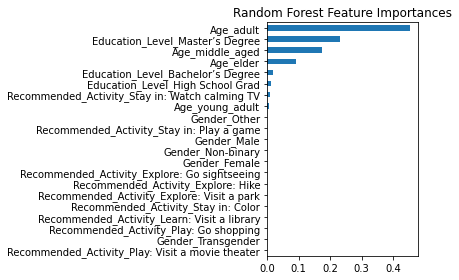

In [53]:
ax = pfi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances")
ax.figure.tight_layout()

In [58]:
plt.savefig('PFI_mitigation.png')

<Figure size 432x288 with 0 Axes>

Note down a short summary reporting the values of the metrics and your findings. This will be the quantitative analysis section of the model card.
- Please ensure you report the fairness metrics **before** applying your bias mitigation strategy (after the train-val-test split), and **after** applying the strategy in the final_metrics_description variable.
- Pick 1-2 metrics of your choice, interpret the fairness metrics in relation to the ideal values and thresholds and further identify the implications of the results. 

In [59]:
final_metrics_description = """
--
--Before:
-- We see that before applying the Bias Mitigation method, there was a higher benefit for the priviliged group (based on the statistical parity difference value)
-- Statistical parity difference value: -0.5676
-- Equal opportunity difference value: -0.0000
--After:
-- After the Bias Mitigation technique, the statistical parity difference value incresed over 0, showing that there is a higher benefit for the unprivileged group.
-- We also see that the equal opportunity difference value slightly decreased (showing a slight higher benefit for the privileged group).
-- However, the change is rather small.
-- Statistical parity difference value: 0.0042
-- Equal opportunity difference value: -0.0005
--
"""

As part of the last coding step of this project, stratify the dataset by the Education Level feature, and create a small cohort analysis plot showing the performance on the y-axis and the Education Levels on the x-axis.

In [60]:
##Fill in
cohort_analysis = orig_test.convert_to_dataframe()[0]
cohort_analysis['Prediction'] = lr_pred

In [61]:
bsc_edu = cohort_analysis.loc[cohort_analysis['Education_Level_Bachelor’s Degree'] == 1]
msc_edu = cohort_analysis.loc[cohort_analysis['Education_Level_Master’s Degree'] == 1]
hs_edu = cohort_analysis.loc[cohort_analysis['Education_Level_High School Grad'] == 1]

In [62]:
bsc_acc = accuracy_score(bsc_edu['Budget (in dollars)_high_budget'], bsc_edu['Prediction'])
msc_acc = accuracy_score(msc_edu['Budget (in dollars)_high_budget'], msc_edu['Prediction'])
hs_acc = accuracy_score(hs_edu['Budget (in dollars)_high_budget'], hs_edu['Prediction'])

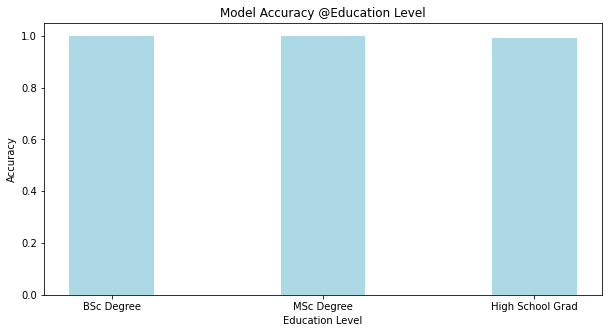

In [63]:
data = {'BSc Degree': bsc_acc,
        'MSc Degree': msc_acc,
        'High School Grad': hs_acc}
names = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(names, values, color ='lightblue', width = 0.4)
 
plt.xlabel("Education Level")
plt.ylabel("Accuracy")
plt.title("Model Accuracy @Education Level")
plt.show()

In [67]:
plt.savefig('cohort_acc.png')

<Figure size 432x288 with 0 Axes>

**Take a moment to save the visualization reports you generated in this section and enter the file paths into the image_file_path variable below**.

In [68]:
#FILL IN - save all visualization plots 
#from the "Apply a bias mitigation strategy" section
#plt.savefig('file_name.png')

#Replace the REPLACE_FILE_NAME placeholder with the image paths
#of the visualizations you have generated for the model card
image_file_path ="""
  <img src="confusion_matrix_mitigation.png"><br/>
  <img src="PFI_mitigation.png"><br/>
  <img src="cohort_acc.png"><br/>
"""

**Optional**: You may choose to create a cohort analysis plot showing the fairness metric values on the y-axis and the Education Levels on the x-axis.

In [ ]:
#Optional save image for the fairness corhort analysis
#plt.savefig('images/optional_fairness_cohort_analysis') 

## Step 6: Articulate the ethical implications

Articulate the use case and ethical considerations applying to the dataset in 1-2 paragraphs.

**Hints:** 
 
- Think about the limitations of the dataset, potential biases that could be introduced into the use case, and the strengths and weaknesses of your ML model.
- Ethical Considerations:
 - Human-in-the-loop considerations: Can users control aspects of the model and inspect the features? If so, briefly describe how?
 - Describe the limitations and types of bias present in the data
 - Describe the failures of the ML model
 - It must include a section on any risk mitigation strategies you applied.
 - Describe Potential harms
 - It must include key contributing factors you found from your interpretability study, both before and after applying the bias mitigation strategy.

- Caveats and Recommendations
 - Potential lack of inclusiveness in the dataset
 - Predisposition of the model to false positives and/or negatives
 - It must also include 1-2 sentences on the further ethical AI analyses you would apply if given more time beyond this project.

In [54]:
#FILL IN
ethical_considerations="""
-- The users can inspect the features of the model since the data come from their input. 
-- However, the model is often percieved as a black box so many people might have difficulties in intepreting the whole process
-- of how the results arise.
-- For mitigating the bias, we chose to apply reweighting to the dataset so that the model "treats" users in more fair way
-- despite their attributes.
-- A potential harm is that some users might not want to provide the required information needed to train the model (we removed the rows where
-- there was a null value). This would affect the results since the model hasn't been trained on such cases, so its accuracy might drop dramatically.
-- Based on the interpretability analysis, we see that most of the features that contributed towards model's accuracy before applying the bias mitigation
-- technique, still play an important role. However, the effect of the Age_young_adult feature on the model accuracy is minimized in the end.
"""
caveats_and_recommendations="""
-- The sample of users may not be a good representation since it is more likely that younger people would use such an app
-- or in general, digital means. Older people might not be that familiar to this tech field or/and might be uninterested in using
-- such activity recommendation apps.
-- Further ethical AI analyses I would apply beyond this project: I would probably apply an additional
-- bias mitigation technique to further enhance the fairness metrics of the models. in addition to this,
-- I might experiment with other types of models as well.
"""

- Business consequences
 - Potential positive impact of the IDOOU Budget Predicter AI
 - Reasons why users may lose trust in the application, and loss of revenue and brand reputation might occur to the organization

In [55]:
business_consequences="""

-- Positive Impact: thanks to the trained model, the app can make suitable suggestions to its users.
-- The fact that the FN rate is higher than the one of the FP, makes us feel less worried that the users won't be satisfied
-- from the recommendations. This is due to the fact that, even if a high-budget user is misclassified a low-budget, the activity wil still
-- be within their budget.

-- Negative Impact: The users might get the same recommendations due to the classification and they might feel
-- they are stereotyped.
"""

## Document the solution in a model card

You're at the finish line! Run the last few blocks of code to generate a simple html file with your model card content and the visualizations you generated for the final version of your model.

Make sure to open the html file and check that it is reflective of your model card content before submitting.

Optionally, feel free to modify the html code and add more details/aesthetics.

In [69]:
html_code = f"""
<html>
  <head>
  </head>
  <body>
  <center><h1>Model Card - IDOOU AI Budget Predicter</h1></center>
  <h2>Model Details</h2>
  {model_details}
  <h2>Intended Use</h2>
  {intended_use}
  <h2>Factors</h2>
  {factors}
  <h2>Metrics</h2>
  {metrics}
  <h2> Training Data </h2>
  {training_data}
  <h2> Evaluation Data </h2>
  {eval_data}
  <h2>Quantitative Analysis</h2>
  #{final_metrics_description}
  
  <br/><br/><b>Results of the AI model after applying the bias mitigation strategy</b><br/>
  
  <center>
  {image_file_path}
  </center>

  <h2>Ethical Considerations</h2>
  {ethical_considerations}
  <h2>Caveats and Recommendations</h2>
  {caveats_and_recommendations}
  <h2>Business Consequences</h2>
  {business_consequences}
  </body>
</html>"""
html_code = html_code.replace('--', '<br>--')

In [70]:
with open('model_card.html', 'w') as f:
    f.write(html_code)

Download and zip the .html report, the images you generated, and this Jupyter notebook, and you're ready for submission!